## Programming Exercise 5 - Regularized Linear Regression and Bias v.s. Variance

In [8]:
# %load ../../../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.optimize import minimize

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

In [9]:
data = loadmat('ex5data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])

In [10]:
y_train = data['y']
X_train = np.c_[np.ones_like(data['X']), data['X']]

yval = data['yval']
Xval = np.c_[np.ones_like(data['Xval']), data['Xval']]


print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('Xval:', Xval.shape)
print('yval:', yval.shape)

X_train: (12, 2)
y_train: (12, 1)
Xval: (21, 2)
yval: (21, 1)


### Regularized Linear Regression

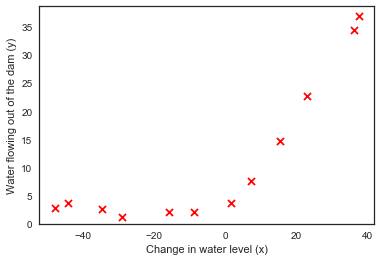

In [6]:
plt.scatter(X_train[:,1], y_train, s=50, c='r', marker='x', linewidths=1)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.ylim(ymin=0);

#### Regularized Cost function

In [7]:
def linearRegCostFunction(theta, X, y, reg):
    m = y.size
    
    h = X.dot(theta)
    
    J = (1/(2*m))*np.sum(np.square(h-y)) + (reg/(2*m))*np.sum(np.square(theta[1:]))
   
    return(J)

#### Gradient

In [8]:
def lrgradientReg(theta, X, y, reg):
    m = y.size
    
    h = X.dot(theta.reshape(-1,1))
        
    grad = (1/m)*(X.T.dot(h-y))+ (reg/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
        
    return(grad.flatten())

In [9]:
initial_theta = np.ones((X_train.shape[1],1))
cost = linearRegCostFunction(initial_theta, X_train, y_train, 0)
gradient = lrgradientReg(initial_theta, X_train, y_train, 0)
print(cost)
print(gradient)

303.9515255535976
[-15.30301567 598.16741084]


In [10]:
def trainLinearReg(X, y, reg):
    #initial_theta = np.zeros((X.shape[1],1))
    initial_theta = np.array([[15],[15]])
    # For some reason the minimize() function does not converge when using
    # zeros as initial theta.
        
    res = minimize(linearRegCostFunction, initial_theta, args=(X,y,reg), method=None, jac=lrgradientReg,
                   options={'maxiter':5000})
    
    return(res)

In [11]:
fit = trainLinearReg(X_train, y_train, 0)
fit

      fun: 1604.4002999186634
 hess_inv: array([[1.03142187, 0.00617881],
       [0.00617881, 0.001215  ]])
      jac: array([ 3.42437190e-12, -5.70371898e-10])
  message: 'Optimization terminated successfully.'
     nfev: 6
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([13.08790351,  0.36777923])

#### Comparison: coefficients and cost obtained with LinearRegression in Scikit-learn

In [12]:
regr = LinearRegression(fit_intercept=False)
regr.fit(X_train, y_train.ravel())
print(regr.coef_)
print(linearRegCostFunction(regr.coef_, X_train, y_train, 0))

[13.08790351  0.36777923]
1604.400299921103


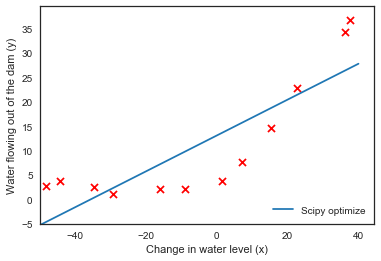

In [13]:
plt.plot(np.linspace(-50,40), (fit.x[0]+ (fit.x[1]*np.linspace(-50,40))), label='Scipy optimize')
#plt.plot(np.linspace(-50,40), (regr.coef_[0]+ (regr.coef_[1]*np.linspace(-50,40))), label='Scikit-learn')
plt.scatter(X_train[:,1], y_train, s=50, c='r', marker='x', linewidths=1)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.ylim(ymin=-5)
plt.xlim(xmin=-50)
plt.legend(loc=4);

In [14]:
def learningCurve(X, y, Xval, yval, reg):
    m = y.size
    
    error_train = np.zeros((m, 1))
    error_val = np.zeros((m, 1))
    
    for i in np.arange(m):
        res = trainLinearReg(X[:i+1], y[:i+1], reg)
        error_train[i] = linearRegCostFunction(res.x, X[:i+1], y[:i+1], reg)
        error_val[i] = linearRegCostFunction(res.x, Xval, yval, reg)
    
    return(error_train, error_val)

In [15]:
t_error, v_error = learningCurve(X_train, y_train, Xval, yval, 0)

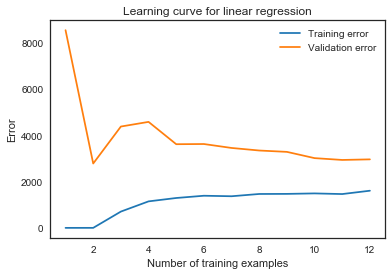

In [16]:
plt.plot(np.arange(1,13), t_error, label='Training error')
plt.plot(np.arange(1,13), v_error, label='Validation error')
plt.title('Learning curve for linear regression')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend();

### Polynomial regression (Scikit-learn)

C:\Users\vivekmenon\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.356625751700443e-26 / 1.1102230246251565e-16
  RuntimeWarning)


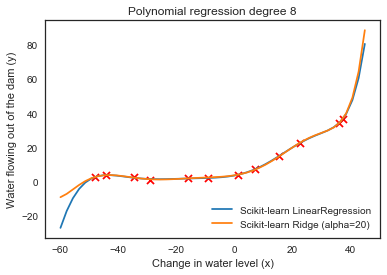

In [17]:
poly = PolynomialFeatures(degree=8)
X_train_poly = poly.fit_transform(X_train[:,1].reshape(-1,1))

regr2 = LinearRegression()
regr2.fit(X_train_poly, y_train)

regr3 = Ridge(alpha=20)
regr3.fit(X_train_poly, y_train)

# plot range for x
plot_x = np.linspace(-60,45)
# using coefficients to calculate y
plot_y = regr2.intercept_+ np.sum(regr2.coef_*poly.fit_transform(plot_x.reshape(-1,1)), axis=1)
plot_y2 = regr3.intercept_ + np.sum(regr3.coef_*poly.fit_transform(plot_x.reshape(-1,1)), axis=1)

plt.plot(plot_x, plot_y, label='Scikit-learn LinearRegression')
plt.plot(plot_x, plot_y2, label='Scikit-learn Ridge (alpha={})'.format(regr3.alpha))
plt.scatter(X_train[:,1], y_train, s=50, c='r', marker='x', linewidths=1)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Polynomial regression degree 8')
plt.legend(loc=4);